# Generative Adversarial Network in Tensorflow

**Generative Adversarial Networks**, introduced by Ian Goodfellow in 2014, are neural nets we can train to _produce_ new images (or other kinds of data) that look as though they came from our true data distribution. In this notebook, we'll implement a small GAN for generating images that look as though they come from the MNIST dataset.

The key insight behind the GAN is to pit two neural networks against each other. On the one hand is the **Generator**, a neural network that takes random noise as input and produces an image as output. On the other hand is the **Discriminator**, which takes in an image and classifies it as real (from MNIST) or fake (from our Generator). During training, we alternate between training the Generator to fool the Discriminator, and training the Discriminator to call the Generator's bluff.

Implementing a GAN in Tensorflow will give you practice turning more involved models into working code, and is also a great showcase for Tensorflow's **variable scope** feature.

## Imports

In [48]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

In [49]:
# For running on a GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

## Loading the data

As in previous examples, we'll use MNIST, because it's a small and easy-to-use dataset that comes bundled with Tensorflow.

In [50]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Utility functions

Let's define some utility functions that will help us quickly construct layers for use in our model. There are two things worth noting here:

1. Instead of `tf.Variable`, we use `tf.get_variable`. 

   The reason for this is a bit subtle, and you may want to skip this and come back to it once you've seen the rest of the code. Here's the basic explanation. Later on in this notebook, we will call `fully_connected_layer` from a couple different places. Sometimes, we will want _new variables_ to be added to the graph, because we are creating an entirely new layer of our network. Other times, however, we will want to use the same weights as an already-existing layer, but acting on different inputs. 
   
   For example, the Discriminator network will appear _twice_ in our computational graph; in one case, the input neurons will be connected to the "real data" placeholder (which we will feed MNIST images), and in the other, they will be connected to the output of the Generator. Although these networks form two separate parts of our computational graph, we want them to share the same weights: conceptually, there is _one_ Discriminator function that gets applied twice, not two different functions altogether. Since `tf.Variable` _always_ creates a new variable when called, it would not be appropriate for use here.
   
   Variable scoping solves this problem. Whenever we are adding nodes to a graph, we are operating within a _scope_. Scopes can be named, and you can create a new scope using `tf.variable_scope('name')` (more on this later). When a scope is open, it can optionally be in _reuse mode_. The result of calling `tf.get_variable` depends on whether you are in reuse mode or not. If not (this is the default), `tf.get_variable` will create a new variable, or cause an error if a variable by the same name already exists in the current scope. If you _are_ in reuse mode, the behavior is the opposite: `tf.get_variable` will look up and return an existing variable (with the specified name) within your scope, or throw an error if it doesn't exist. By carefully controlling our scopes later on, we can create exactly the graph we want, with variables shared across the graph where appropriate.

2. The `variables_from_scope` function lists all variables created within a given scope. This will be useful later, when we want to update all "discriminator" variables, but no "generator" variables, or vice versa.

In [51]:
def shape(tensor):
    """
    Get the shape of a tensor. This is a compile-time operation,
    meaning that it runs when building the graph, not running it.
    This means that it cannot know the shape of any placeholders 
    or variables with shape determined by feed_dict.
    """
    return tuple([d.value for d in tensor.get_shape()])

def fully_connected_layer(in_tensor, out_units, activation_function=tf.nn.relu):
    """
    Add a fully connected layer to the default graph, taking as input `in_tensor`, and
    creating a hidden layer of `out_units` neurons. This should be called within a unique variable
    scope. Creates variables W and b, and computes activation_function(in * W + b).
    """
    _, num_features = shape(in_tensor)
    W = tf.get_variable("weights", [num_features, out_units], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b = tf.get_variable("biases", [out_units], initializer=tf.constant_initializer(0.1))
    return activation_function(tf.matmul(in_tensor, W) + b)

def variables_from_scope(scope_name):
    """
    Returns a list of all variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope_name)

We'll also provide a simple function for displaying a few 28-pixel images. This will help us understand the progress of our GAN as it trains; we'll use it to visualize the generated 'fake digit' images.

In [52]:
def visualize_row(images, img_width=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a column
    in a plot, using `cmap` to map from numbers to colors.
    """
    im = np.reshape(images, [-1, img_width])
    plt.figure()
    plt.imshow(im, cmap=cmap)
    plt.show()

## Generator

A GAN is made up of two smaller networks: a generator and a discriminator. The generator is responsible for sampling images from a distribution that we hope will get closer and closer, as we train, to the real data distribution.

Neural networks are deterministic, so in order to sample a new image from the generator, we first create some random noise `z` (in our case, `z` will be a 100-dimensional uniform random variable) and then feed that noise to the network. You can think of `z` as being a latent, low-dimensional representation of some image `G(z)`, though in a vanilla GAN, it is usually difficult to interpret `z`'s components in a meaningful way.

Our generator is a dead-simple multi-layer perceptron (feed-forward network), with 128 hidden units.

In [53]:
def generator(z):
    """
    Given random noise `z`, use a simple MLP with 128 hidden units to generate a
    sample image (784 values between 0 and 1, enforced with the sigmoid function).
    """
    with tf.variable_scope("fc1"):
        fc1 = fully_connected_layer(z, 128)
    with tf.variable_scope("fc2"):
        return fully_connected_layer(fc1, 784, activation_function=tf.sigmoid)

## Discriminator

Although it isn't necesssary, it makes some sense for our discriminator to mirror the generator's architecture, as we do here. The discriminator takes in an image (perhaps a real one from the MNIST dataset, perhaps a fake one from our generator), and attempts to classify it as real (1) or fake (0). Our architecture is again a simple MLP, taking 784 pixels down to 128 hidden units, and finally down to a probability.

In [54]:
def discriminator(x):
    """
    This discriminator network takes in a tensor with shape [batch, 784], and classifies
    each example image as real or fake. The network it uses is quite simple: a fully connected
    layer with ReLU activation takes us down to 128 dimensions, then we collapse that to 1 number 
    in [0, 1] using a fully-connected layer with sigmoid activation. The result can be interpreted
    as a probability, the discriminator's strength-of-belief that a sample is from the 
    real data distribution.
    """
    with tf.variable_scope("fc1"):
        fc1 = fully_connected_layer(x, 128)
    with tf.variable_scope("fc2"):
        return fully_connected_layer(fc1, 1, activation_function=tf.sigmoid)

## GAN

Given a generator and discriminator, we can now set up the GAN's computational graph. 

We use Tensorflow's variable scope feature for two purposes. 

1. First, it helps separate the variables used by the generator and by the discriminator; this is important, because when training, we want to alternate between updating each set of variables according to a different objective. 

2. Second, scoping helps us reuse the same set of discriminator weights both for the operations we perform on _real_ images and for those performed on _fake_ images. To achieve this, after calling `discriminator` for the first time (and creating these weight variables), we tell our current scope to `reuse_variables()`, meaning that on our next call to `discriminator`, existing variables will be reused rather than creating new ones.

In [55]:
def gan(batch_size, z_dim):
    """
    Given some details about the training procedure (batch size, dimension of z),
    this function sets up the rest of the computational graph for the GAN.
    It returns a dictionary containing six ops/tensors: `train_d` and `train_g`, the 
    optimization steps for the discriminator and generator, `real_data` and `noise`, 
    two placeholders that should be fed in during training, `d_loss`, the discriminator loss
    (useful for estimating progress toward convergence), and `fake_data`, which can be 
    evaluated (with noise in the feed_dict) to sample from the generator's distribution.
    """
    z = tf.placeholder(tf.float32, [batch_size, z_dim], name='z')
    x = tf.placeholder(tf.float32, [batch_size, 784], name='x')

    with tf.variable_scope('generator'):
        fake_x = generator(z)

    with tf.variable_scope('discriminator') as scope:
        d_on_real = discriminator(x)
        scope.reuse_variables()
        d_on_fake = discriminator(fake_x)

    g_loss = -tf.reduce_mean(tf.log(d_on_fake))
    d_loss = -tf.reduce_mean(tf.log(d_on_real) + tf.log(1. - d_on_fake))

    optimize_d = tf.train.AdamOptimizer().minimize(d_loss, var_list=variables_from_scope("discriminator"))
    optimize_g = tf.train.AdamOptimizer().minimize(g_loss, var_list=variables_from_scope("generator"))

    return {'train_d': optimize_d,
            'train_g': optimize_g,
            'd_loss': d_loss,
            'fake_data': fake_x,
            'real_data': x,
            'noise': z}

## Training a GAN

Our training procedure is a bit more involved than in past demos. Here are the main differences:
1. Each iteration, we first train the generator, then (separately) the discriminator.
2. Each iteration, we need to feed in a batch of images, just as in previous notebooks. But we also need a batch of noise samples. For this, we use Numpy's `np.random.uniform` function.
3. Every 100 iterations, we log some data to the console and visualize a few samples from our generator.

In [58]:
def train_gan(iterations, batch_size=50, z_dim=100):
    """
    Construct and train the GAN.
    """
    model = gan(batch_size=batch_size, z_dim=z_dim)
    
    def make_noise():
        return np.random.uniform(-1.0, 1.0, [batch_size, z_dim])

    def next_feed_dict():
        return {model['real_data']: mnist.train.next_batch(batch_size)[0],
                model['noise']: make_noise()}
        
    initialize_all = tf.global_variables_initializer()
    with tf.Session(config=config) as sess:
        sess.run(initialize_all)
        start_time = time.time()
        for t in range(iterations):
            sess.run(model['train_g'], feed_dict=next_feed_dict())
            _, d_loss = sess.run([model['train_d'], model['d_loss']], feed_dict=next_feed_dict())

            if t % 100 == 0 or t+1 == iterations:
                fake_data = sess.run(model['fake_data'], feed_dict={model['noise']: make_noise()})
                print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, d_loss))
                visualize_row(fake_data[:5])

## Moment of truth

It's time to run our GAN! Watch as it learns to draw recognizable digits faster than a Kindergartener.

Iter [       0] Time [0.0780] d_loss [2.6183]


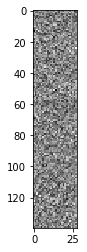

Iter [     100] Time [1.2504] d_loss [0.0461]


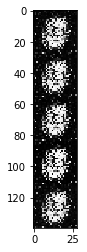

Iter [     200] Time [2.2736] d_loss [0.0901]


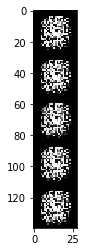

Iter [     300] Time [3.5581] d_loss [0.0868]


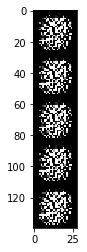

Iter [     400] Time [4.9694] d_loss [0.0602]


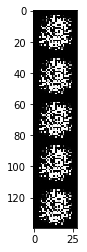

Iter [     500] Time [6.1341] d_loss [0.0382]


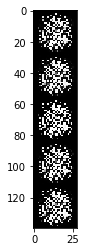

Iter [     600] Time [7.4219] d_loss [0.0125]


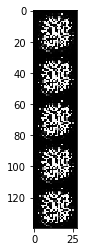

Iter [     700] Time [8.9065] d_loss [0.0244]


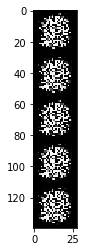

Iter [     800] Time [10.1349] d_loss [0.0160]


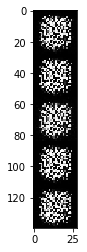

Iter [     900] Time [11.3997] d_loss [0.0065]


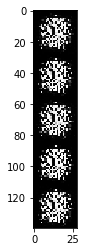

Iter [    1000] Time [12.5511] d_loss [0.0396]


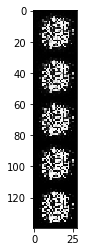

Iter [    1100] Time [13.9647] d_loss [0.0089]


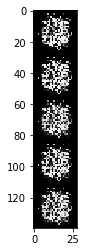

Iter [    1200] Time [15.3133] d_loss [0.0247]


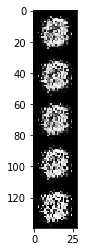

Iter [    1300] Time [16.6031] d_loss [0.0222]


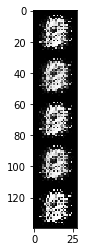

Iter [    1400] Time [17.8379] d_loss [0.0243]


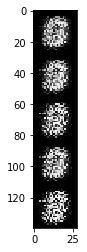

Iter [    1500] Time [19.1378] d_loss [0.0293]


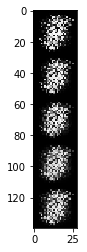

Iter [    1600] Time [20.4091] d_loss [0.0329]


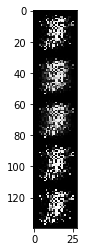

Iter [    1700] Time [21.7626] d_loss [0.0131]


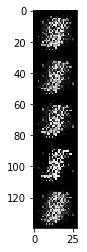

Iter [    1800] Time [22.8405] d_loss [0.0258]


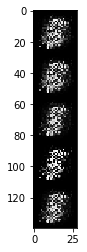

Iter [    1900] Time [24.0409] d_loss [0.0232]


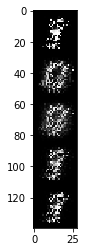

Iter [    2000] Time [25.2939] d_loss [0.0307]


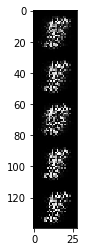

Iter [    2100] Time [26.5189] d_loss [0.0428]


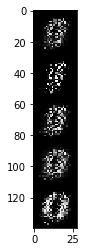

Iter [    2200] Time [27.8391] d_loss [0.0360]


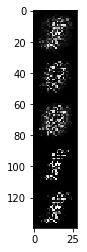

Iter [    2300] Time [29.2116] d_loss [0.0291]


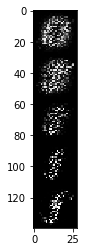

Iter [    2400] Time [30.5616] d_loss [0.0554]


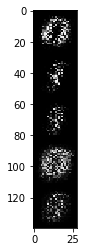

Iter [    2500] Time [31.7526] d_loss [0.0285]


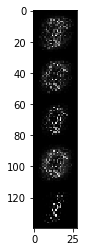

Iter [    2600] Time [32.8796] d_loss [0.0741]


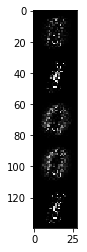

Iter [    2700] Time [34.1290] d_loss [0.0439]


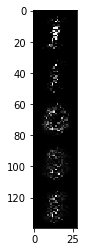

Iter [    2800] Time [35.3850] d_loss [0.0308]


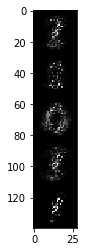

Iter [    2900] Time [36.5728] d_loss [0.0809]


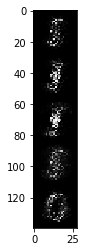

Iter [    3000] Time [37.7503] d_loss [0.0780]


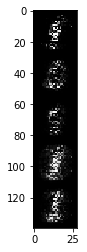

Iter [    3100] Time [39.0140] d_loss [0.0580]


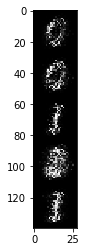

Iter [    3200] Time [40.2077] d_loss [0.1045]


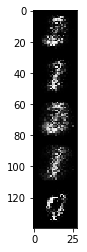

Iter [    3300] Time [41.5202] d_loss [0.0987]


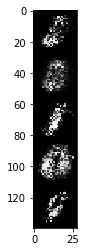

Iter [    3400] Time [42.7372] d_loss [0.0610]


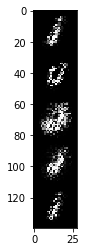

Iter [    3500] Time [43.9730] d_loss [0.0929]


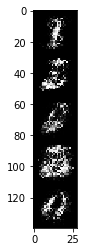

Iter [    3600] Time [45.2300] d_loss [0.0519]


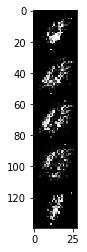

Iter [    3700] Time [46.5950] d_loss [0.0616]


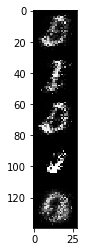

Iter [    3800] Time [47.8173] d_loss [0.0917]


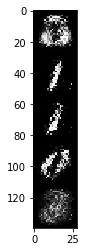

Iter [    3900] Time [49.1747] d_loss [0.2019]


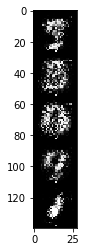

Iter [    4000] Time [50.5303] d_loss [0.1189]


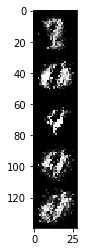

Iter [    4100] Time [51.8124] d_loss [0.0739]


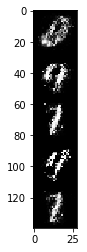

Iter [    4200] Time [52.9141] d_loss [0.1644]


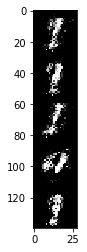

Iter [    4300] Time [54.1517] d_loss [0.0808]


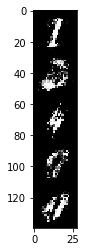

Iter [    4400] Time [55.4265] d_loss [0.1365]


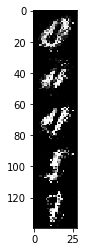

Iter [    4500] Time [56.7063] d_loss [0.1279]


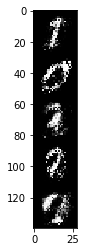

Iter [    4600] Time [57.9374] d_loss [0.1270]


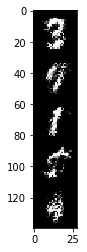

Iter [    4700] Time [59.1697] d_loss [0.1832]


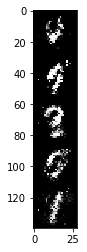

Iter [    4800] Time [60.3856] d_loss [0.1344]


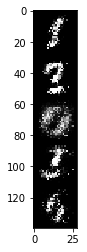

Iter [    4900] Time [61.5765] d_loss [0.1577]


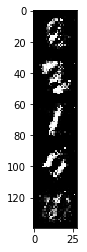

Iter [    5000] Time [62.1160] d_loss [0.2161]


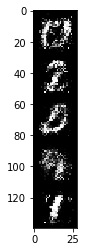

Iter [    5100] Time [62.5572] d_loss [0.2096]


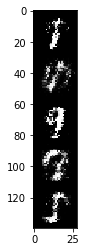

Iter [    5200] Time [62.9274] d_loss [0.1305]


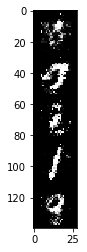

Iter [    5300] Time [63.3752] d_loss [0.1919]


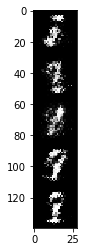

Iter [    5400] Time [63.8111] d_loss [0.2219]


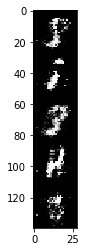

Iter [    5500] Time [64.4088] d_loss [0.3273]


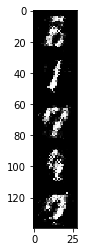

Iter [    5600] Time [64.8211] d_loss [0.2565]


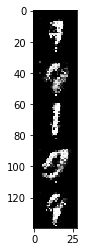

Iter [    5700] Time [65.2624] d_loss [0.3414]


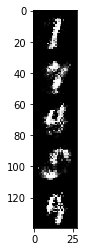

Iter [    5800] Time [65.6547] d_loss [0.4437]


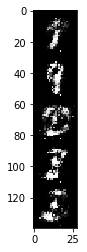

Iter [    5900] Time [66.1100] d_loss [0.4450]


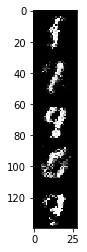

Iter [    6000] Time [66.5993] d_loss [0.2282]


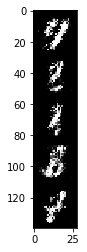

Iter [    6100] Time [67.0470] d_loss [0.2604]


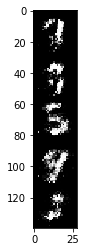

Iter [    6200] Time [67.4709] d_loss [0.4268]


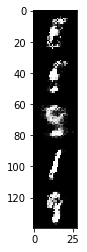

Iter [    6300] Time [67.8010] d_loss [0.2941]


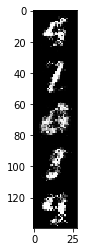

Iter [    6400] Time [68.2409] d_loss [0.2038]


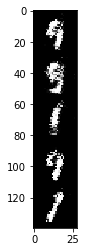

Iter [    6500] Time [68.6206] d_loss [0.7320]


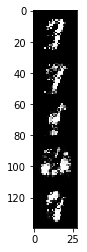

Iter [    6600] Time [69.0770] d_loss [0.3428]


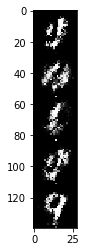

Iter [    6700] Time [69.4649] d_loss [0.4240]


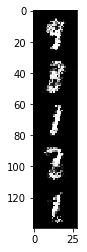

Iter [    6800] Time [69.9221] d_loss [0.3686]


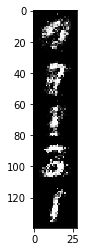

Iter [    6900] Time [70.3539] d_loss [0.3037]


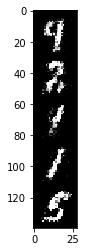

Iter [    7000] Time [70.7738] d_loss [0.3363]


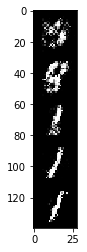

Iter [    7100] Time [71.2951] d_loss [0.3526]


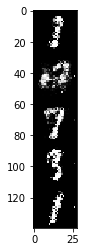

Iter [    7200] Time [71.8006] d_loss [0.2743]


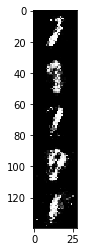

Iter [    7300] Time [72.2348] d_loss [0.4840]


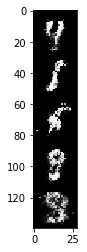

Iter [    7400] Time [72.6318] d_loss [0.4169]


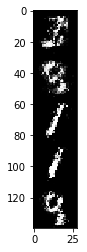

Iter [    7500] Time [73.0397] d_loss [0.5201]


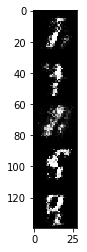

Iter [    7600] Time [73.5025] d_loss [0.2117]


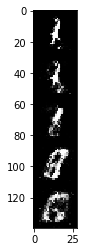

Iter [    7700] Time [73.9121] d_loss [0.5859]


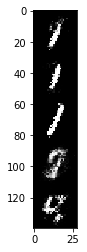

Iter [    7800] Time [74.3371] d_loss [0.4059]


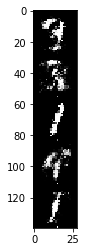

Iter [    7900] Time [74.7085] d_loss [0.5108]


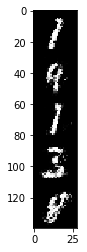

Iter [    8000] Time [75.1497] d_loss [0.3067]


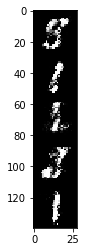

Iter [    8100] Time [75.5656] d_loss [0.8937]


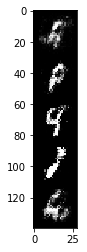

Iter [    8200] Time [75.9933] d_loss [0.5203]


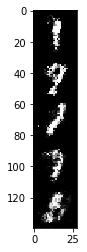

Iter [    8300] Time [76.4390] d_loss [0.4171]


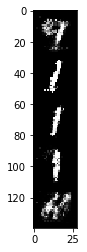

Iter [    8400] Time [76.7956] d_loss [0.5694]


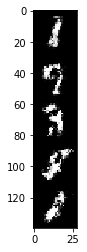

Iter [    8500] Time [77.2093] d_loss [0.3899]


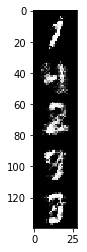

Iter [    8600] Time [77.6576] d_loss [0.6738]


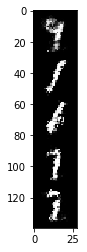

Iter [    8700] Time [78.1589] d_loss [0.3780]


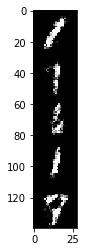

Iter [    8800] Time [78.6639] d_loss [0.3101]


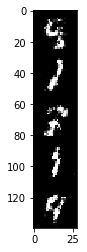

Iter [    8900] Time [79.1056] d_loss [0.5345]


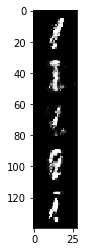

Iter [    9000] Time [79.4998] d_loss [0.6526]


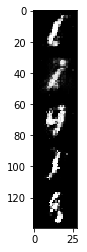

Iter [    9100] Time [80.0141] d_loss [0.6293]


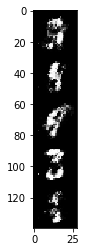

Iter [    9200] Time [80.4262] d_loss [0.4966]


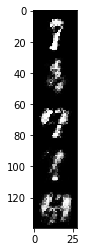

Iter [    9300] Time [80.8550] d_loss [0.3471]


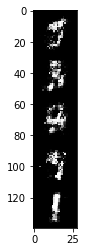

Iter [    9400] Time [81.3625] d_loss [0.3871]


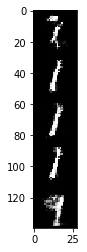

Iter [    9500] Time [81.7865] d_loss [0.5733]


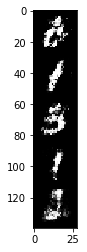

Iter [    9600] Time [82.2307] d_loss [0.5031]


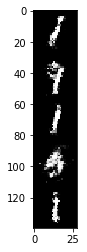

Iter [    9700] Time [82.6765] d_loss [0.3989]


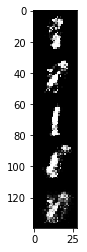

Iter [    9800] Time [83.0882] d_loss [0.4026]


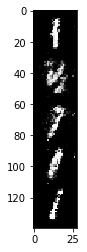

Iter [    9900] Time [83.5267] d_loss [0.6056]


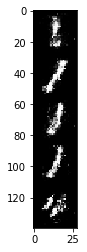

Iter [   10000] Time [83.9761] d_loss [0.5152]


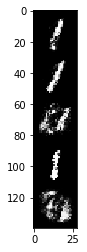

Iter [   10100] Time [84.4578] d_loss [0.7509]


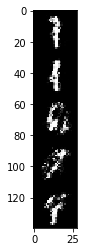

Iter [   10200] Time [84.9175] d_loss [0.3457]


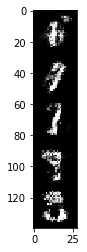

Iter [   10300] Time [85.5070] d_loss [0.7805]


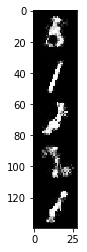

Iter [   10400] Time [85.9063] d_loss [0.5611]


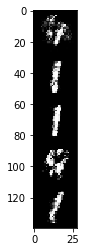

Iter [   10500] Time [86.3700] d_loss [0.5427]


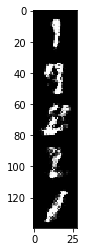

Iter [   10600] Time [86.8259] d_loss [0.5626]


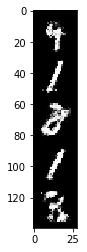

Iter [   10700] Time [87.2465] d_loss [0.4441]


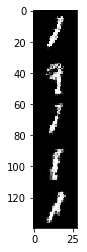

Iter [   10800] Time [87.6351] d_loss [0.6500]


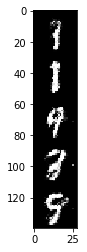

Iter [   10900] Time [88.0152] d_loss [0.7260]


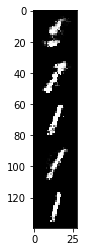

Iter [   11000] Time [88.5554] d_loss [0.5669]


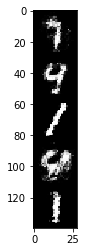

Iter [   11100] Time [88.9531] d_loss [0.6850]


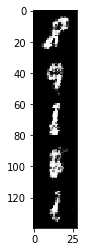

Iter [   11200] Time [89.3425] d_loss [0.6968]


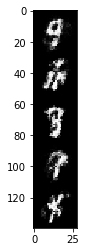

Iter [   11300] Time [89.7416] d_loss [0.6956]


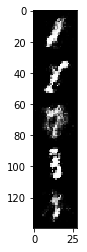

Iter [   11400] Time [90.1154] d_loss [0.7596]


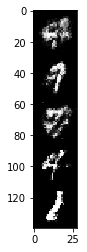

Iter [   11500] Time [90.5647] d_loss [0.6393]


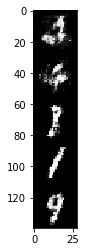

Iter [   11600] Time [91.0397] d_loss [0.3622]


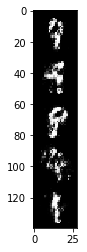

Iter [   11700] Time [91.4915] d_loss [0.4527]


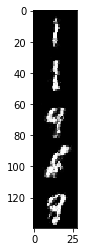

Iter [   11800] Time [91.8753] d_loss [0.6846]


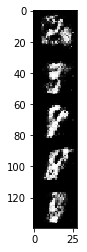

Iter [   11900] Time [92.3879] d_loss [0.7326]


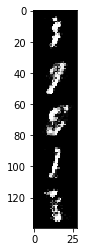

Iter [   12000] Time [92.7678] d_loss [0.5620]


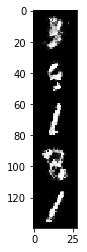

Iter [   12100] Time [93.2778] d_loss [0.3778]


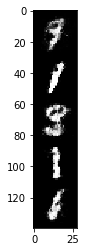

Iter [   12200] Time [93.6219] d_loss [0.8894]


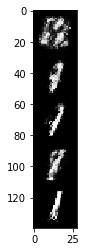

Iter [   12300] Time [94.0685] d_loss [0.5158]


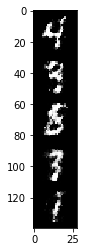

Iter [   12400] Time [94.4521] d_loss [0.5321]


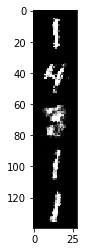

Iter [   12500] Time [94.9143] d_loss [0.8845]


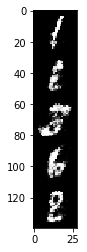

Iter [   12600] Time [95.3428] d_loss [0.6717]


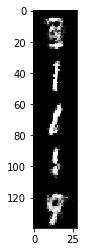

Iter [   12700] Time [96.1946] d_loss [0.6229]


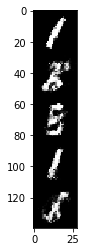

Iter [   12800] Time [97.2725] d_loss [0.5704]


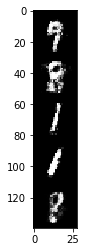

Iter [   12900] Time [98.4942] d_loss [0.6378]


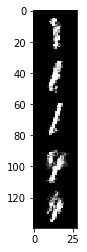

Iter [   13000] Time [99.6840] d_loss [0.6672]


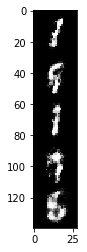

Iter [   13100] Time [100.8726] d_loss [0.6701]


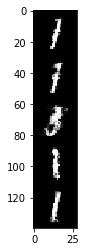

Iter [   13200] Time [102.0630] d_loss [0.6904]


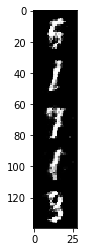

Iter [   13300] Time [103.3217] d_loss [0.5240]


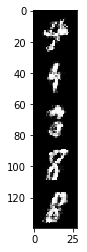

Iter [   13400] Time [104.5344] d_loss [0.7865]


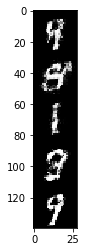

Iter [   13500] Time [105.7960] d_loss [0.7234]


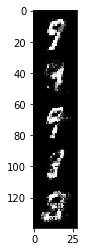

Iter [   13600] Time [107.0002] d_loss [0.4593]


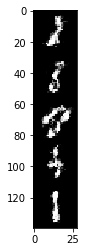

Iter [   13700] Time [108.1093] d_loss [0.3654]


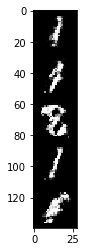

Iter [   13800] Time [109.3074] d_loss [0.7209]


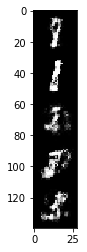

Iter [   13900] Time [110.5767] d_loss [0.7622]


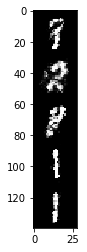

Iter [   14000] Time [111.8554] d_loss [0.6671]


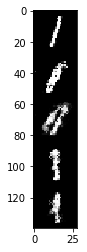

Iter [   14100] Time [113.0597] d_loss [0.9028]


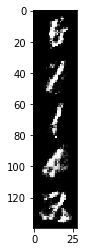

Iter [   14200] Time [114.3301] d_loss [0.7376]


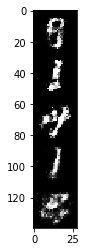

Iter [   14300] Time [115.5524] d_loss [0.8476]


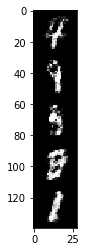

Iter [   14400] Time [116.8079] d_loss [0.4244]


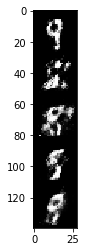

Iter [   14500] Time [118.1374] d_loss [0.7899]


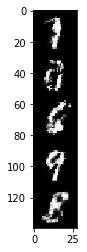

Iter [   14600] Time [119.3135] d_loss [0.6457]


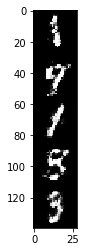

Iter [   14700] Time [120.5324] d_loss [0.6651]


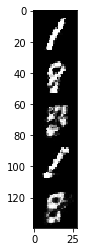

Iter [   14800] Time [121.8153] d_loss [1.0367]


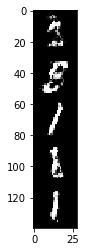

Iter [   14900] Time [123.2112] d_loss [0.8352]


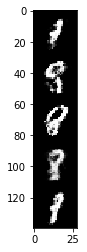

Iter [   15000] Time [124.3938] d_loss [0.5784]


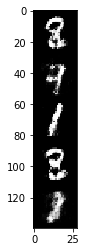

Iter [   15100] Time [125.7849] d_loss [0.8370]


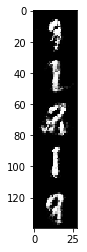

Iter [   15200] Time [127.0027] d_loss [0.9020]


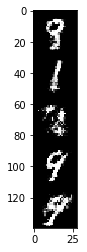

Iter [   15300] Time [128.2639] d_loss [0.4602]


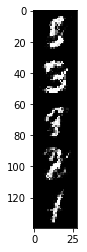

Iter [   15400] Time [129.5538] d_loss [0.5798]


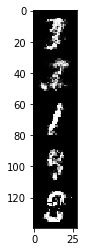

Iter [   15500] Time [130.8832] d_loss [0.6910]


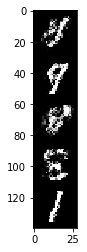

Iter [   15600] Time [132.1991] d_loss [0.5867]


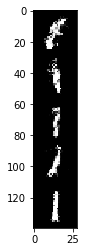

Iter [   15700] Time [133.5379] d_loss [0.5541]


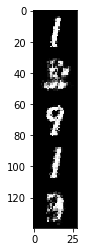

Iter [   15800] Time [134.6886] d_loss [0.5821]


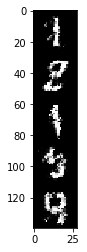

Iter [   15900] Time [135.8938] d_loss [0.4151]


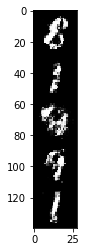

Iter [   16000] Time [137.3104] d_loss [0.7573]


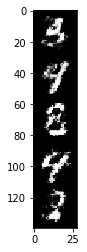

Iter [   16100] Time [138.5591] d_loss [0.7281]


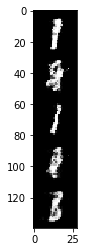

Iter [   16200] Time [139.8021] d_loss [0.8092]


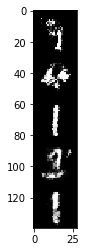

Iter [   16300] Time [141.0486] d_loss [0.6046]


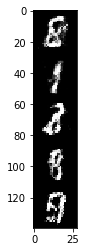

Iter [   16400] Time [142.3694] d_loss [0.6645]


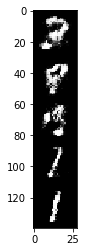

Iter [   16500] Time [143.6812] d_loss [0.6809]


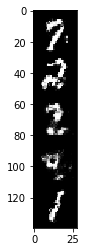

Iter [   16600] Time [144.8051] d_loss [0.7404]


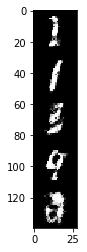

Iter [   16700] Time [146.1640] d_loss [0.6326]


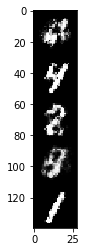

Iter [   16800] Time [147.3866] d_loss [0.8139]


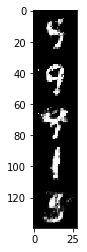

Iter [   16900] Time [148.6947] d_loss [0.8381]


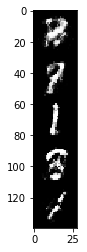

Iter [   17000] Time [150.0102] d_loss [0.7174]


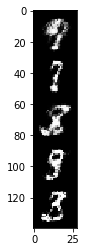

Iter [   17100] Time [151.4596] d_loss [0.6975]


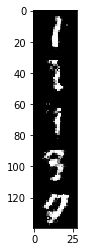

Iter [   17200] Time [152.7053] d_loss [0.6146]


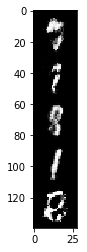

Iter [   17300] Time [153.9129] d_loss [0.6443]


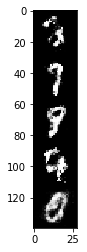

Iter [   17400] Time [155.0517] d_loss [0.6146]


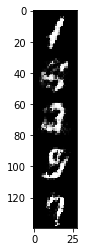

Iter [   17500] Time [156.3369] d_loss [0.7152]


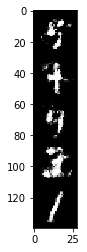

Iter [   17600] Time [157.6841] d_loss [0.7872]


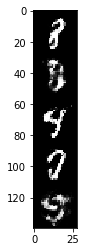

Iter [   17700] Time [158.8645] d_loss [0.5873]


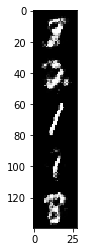

Iter [   17800] Time [160.1560] d_loss [0.7702]


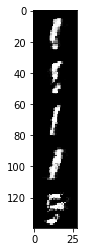

Iter [   17900] Time [161.3654] d_loss [0.6263]


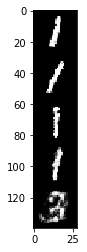

Iter [   18000] Time [162.6049] d_loss [0.9288]


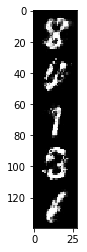

Iter [   18100] Time [163.8287] d_loss [0.9243]


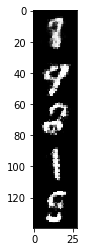

Iter [   18200] Time [165.1217] d_loss [0.5488]


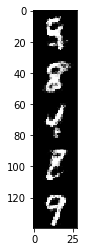

Iter [   18300] Time [166.5238] d_loss [0.6191]


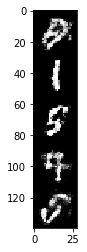

Iter [   18400] Time [167.7482] d_loss [0.6505]


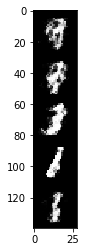

Iter [   18500] Time [168.9599] d_loss [0.6472]


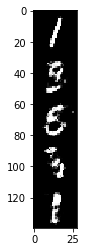

Iter [   18600] Time [170.2196] d_loss [0.7066]


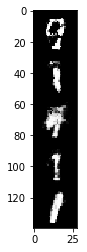

Iter [   18700] Time [171.6651] d_loss [0.6333]


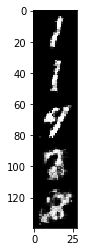

Iter [   18800] Time [172.8944] d_loss [0.6133]


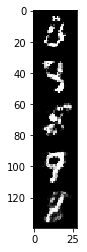

Iter [   18900] Time [174.1011] d_loss [0.8384]


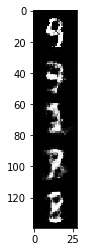

Iter [   19000] Time [175.3489] d_loss [0.4612]


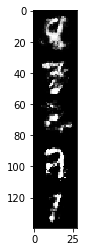

Iter [   19100] Time [176.5238] d_loss [0.7714]


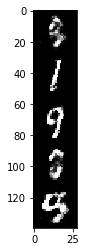

Iter [   19200] Time [177.8313] d_loss [0.9224]


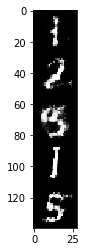

Iter [   19300] Time [179.1246] d_loss [0.6993]


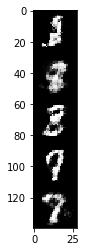

Iter [   19400] Time [180.3340] d_loss [0.9429]


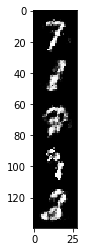

Iter [   19500] Time [181.5378] d_loss [0.8997]


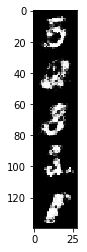

Iter [   19600] Time [182.7514] d_loss [0.6032]


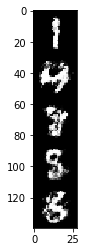

Iter [   19700] Time [183.9908] d_loss [0.6294]


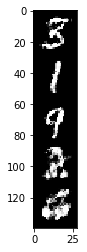

Iter [   19800] Time [185.3239] d_loss [0.7159]


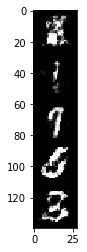

Iter [   19900] Time [186.4874] d_loss [0.7769]


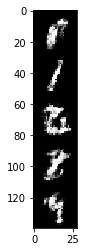

Iter [   20000] Time [187.6792] d_loss [0.7521]


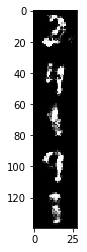

Iter [   20100] Time [188.8117] d_loss [0.6104]


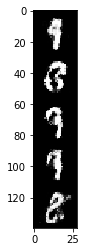

Iter [   20200] Time [190.0369] d_loss [0.7872]


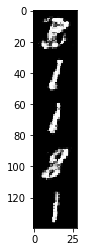

Iter [   20300] Time [191.1352] d_loss [0.8207]


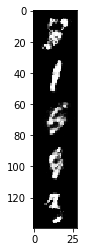

Iter [   20400] Time [192.3254] d_loss [0.8276]


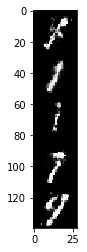

Iter [   20500] Time [193.4636] d_loss [0.5739]


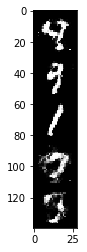

Iter [   20600] Time [194.7416] d_loss [0.6661]


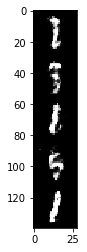

Iter [   20700] Time [195.7782] d_loss [0.5968]


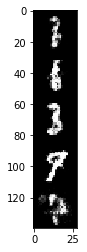

Iter [   20800] Time [196.9457] d_loss [0.8466]


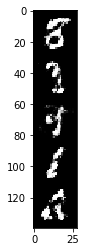

Iter [   20900] Time [198.2086] d_loss [0.8598]


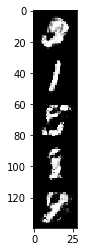

Iter [   21000] Time [199.4067] d_loss [0.6351]


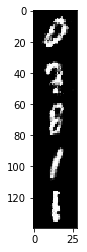

Iter [   21100] Time [200.5611] d_loss [0.6902]


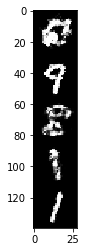

Iter [   21200] Time [201.7934] d_loss [0.7637]


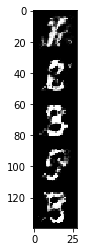

Iter [   21300] Time [202.9899] d_loss [0.6360]


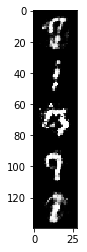

Iter [   21400] Time [204.2679] d_loss [0.7148]


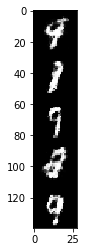

Iter [   21500] Time [205.3821] d_loss [0.5594]


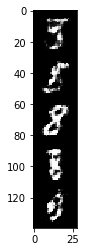

Iter [   21600] Time [206.5668] d_loss [0.6126]


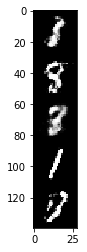

Iter [   21700] Time [207.7180] d_loss [0.5779]


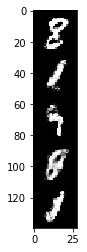

Iter [   21800] Time [208.9660] d_loss [0.7722]


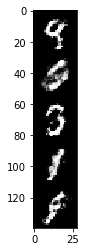

Iter [   21900] Time [210.1655] d_loss [0.5063]


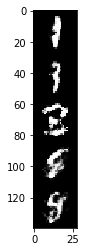

Iter [   22000] Time [211.4334] d_loss [0.6073]


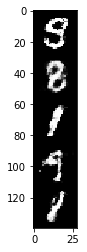

Iter [   22100] Time [212.6711] d_loss [0.7998]


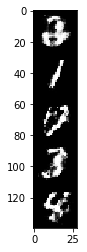

Iter [   22200] Time [213.9336] d_loss [0.8353]


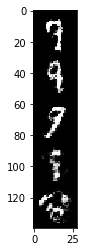

Iter [   22300] Time [215.1408] d_loss [0.8421]


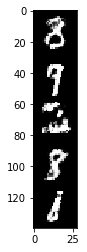

Iter [   22400] Time [216.3145] d_loss [0.8700]


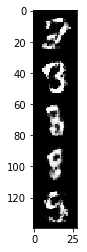

Iter [   22500] Time [217.5771] d_loss [0.7173]


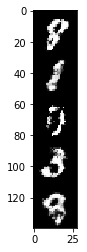

Iter [   22600] Time [218.9913] d_loss [1.1529]


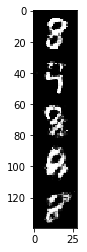

Iter [   22700] Time [220.2413] d_loss [0.7003]


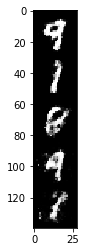

Iter [   22800] Time [221.5223] d_loss [0.6819]


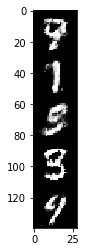

Iter [   22900] Time [222.7827] d_loss [0.6796]


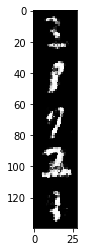

Iter [   23000] Time [224.0180] d_loss [0.6225]


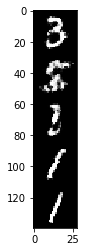

Iter [   23100] Time [225.4548] d_loss [0.7257]


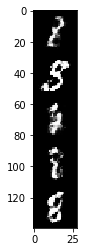

Iter [   23200] Time [226.7212] d_loss [0.7810]


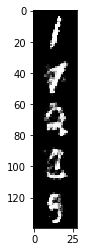

Iter [   23300] Time [227.9422] d_loss [0.8286]


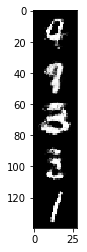

Iter [   23400] Time [229.1571] d_loss [0.6875]


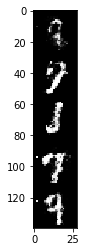

Iter [   23500] Time [230.5063] d_loss [0.6325]


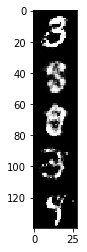

Iter [   23600] Time [231.7439] d_loss [0.6580]


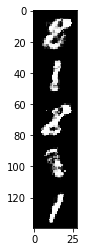

Iter [   23700] Time [233.1086] d_loss [0.4919]


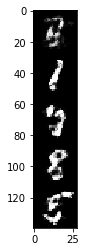

Iter [   23800] Time [234.4180] d_loss [0.5844]


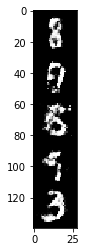

Iter [   23900] Time [235.6403] d_loss [0.7662]


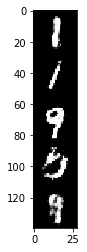

Iter [   24000] Time [236.8891] d_loss [0.7884]


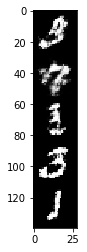

Iter [   24100] Time [238.2053] d_loss [0.8628]


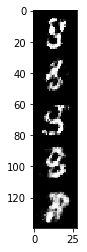

Iter [   24200] Time [239.4091] d_loss [0.7638]


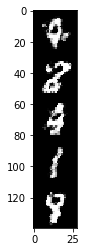

Iter [   24300] Time [240.6481] d_loss [0.8361]


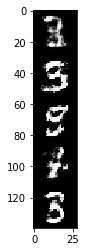

Iter [   24400] Time [241.9191] d_loss [0.8051]


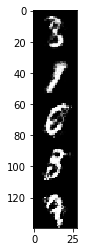

Iter [   24500] Time [243.2161] d_loss [0.5265]


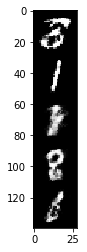

Iter [   24600] Time [244.4004] d_loss [0.5743]


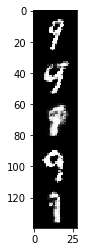

Iter [   24700] Time [244.9648] d_loss [0.6405]


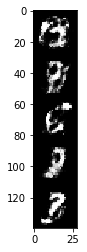

Iter [   24800] Time [245.4495] d_loss [0.6047]


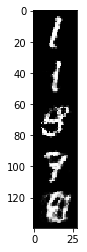

Iter [   24900] Time [245.8787] d_loss [0.5338]


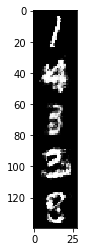

Iter [   25000] Time [246.2677] d_loss [0.8189]


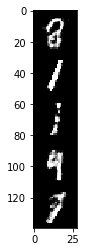

Iter [   25100] Time [246.6906] d_loss [0.8420]


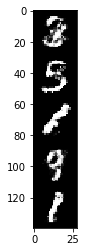

Iter [   25200] Time [247.0694] d_loss [0.4918]


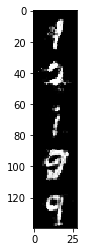

Iter [   25300] Time [247.5161] d_loss [0.6483]


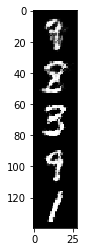

Iter [   25400] Time [247.9634] d_loss [0.6723]


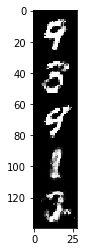

Iter [   25500] Time [248.3596] d_loss [0.5020]


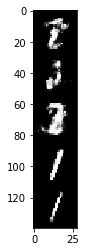

Iter [   25600] Time [248.7595] d_loss [0.8499]


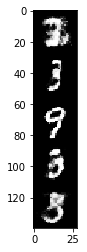

Iter [   25700] Time [249.1790] d_loss [0.5866]


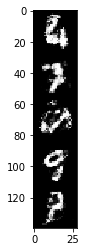

Iter [   25800] Time [249.6300] d_loss [0.5486]


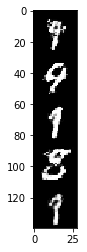

Iter [   25900] Time [250.0838] d_loss [0.9106]


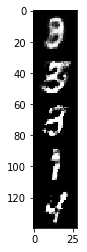

Iter [   26000] Time [250.4753] d_loss [0.6461]


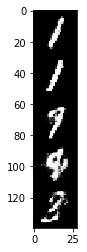

Iter [   26100] Time [250.8807] d_loss [0.8817]


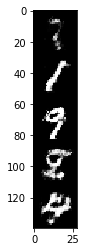

Iter [   26200] Time [251.3483] d_loss [0.6378]


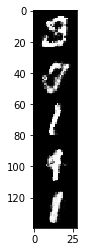

Iter [   26300] Time [251.8920] d_loss [0.6020]


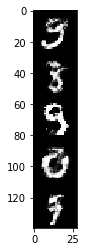

Iter [   26400] Time [252.3918] d_loss [0.7341]


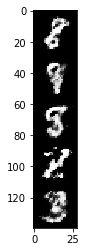

Iter [   26500] Time [252.8244] d_loss [0.6490]


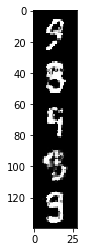

Iter [   26600] Time [253.2397] d_loss [0.6708]


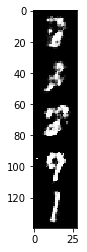

Iter [   26700] Time [253.6600] d_loss [0.4842]


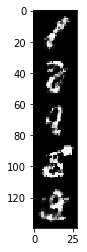

Iter [   26800] Time [254.0913] d_loss [0.8110]


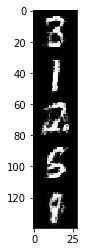

Iter [   26900] Time [254.4728] d_loss [0.5523]


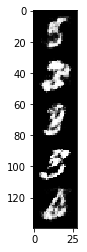

Iter [   27000] Time [254.9551] d_loss [0.8979]


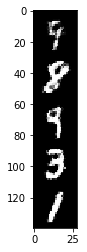

Iter [   27100] Time [255.4054] d_loss [0.8036]


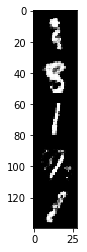

Iter [   27200] Time [255.8056] d_loss [0.7502]


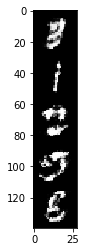

Iter [   27300] Time [256.1925] d_loss [0.5979]


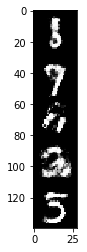

Iter [   27400] Time [256.5774] d_loss [0.5432]


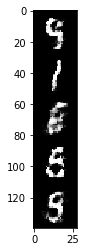

Iter [   27500] Time [257.0531] d_loss [0.5687]


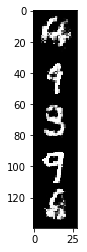

Iter [   27600] Time [257.4835] d_loss [0.6643]


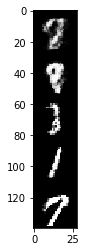

Iter [   27700] Time [257.9107] d_loss [0.6626]


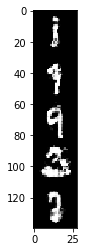

Iter [   27800] Time [258.2784] d_loss [0.6656]


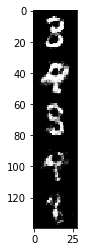

Iter [   27900] Time [258.8045] d_loss [0.7323]


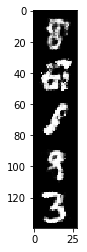

Iter [   28000] Time [259.2197] d_loss [0.6819]


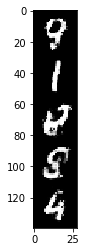

Iter [   28100] Time [259.7741] d_loss [0.5197]


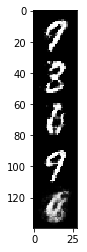

Iter [   28200] Time [260.1824] d_loss [0.5125]


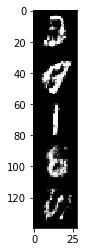

Iter [   28300] Time [260.5797] d_loss [0.6575]


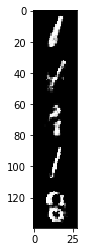

Iter [   28400] Time [260.9841] d_loss [0.6800]


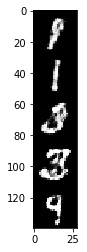

Iter [   28500] Time [261.4090] d_loss [0.6320]


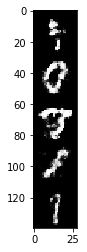

Iter [   28600] Time [261.8273] d_loss [0.6800]


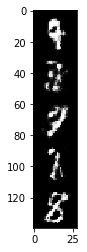

Iter [   28700] Time [262.2019] d_loss [0.8160]


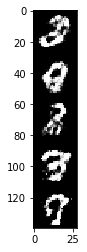

Iter [   28800] Time [262.6385] d_loss [0.6249]


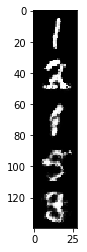

Iter [   28900] Time [263.0654] d_loss [0.7166]


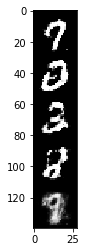

Iter [   29000] Time [263.4884] d_loss [0.7101]


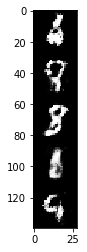

Iter [   29100] Time [263.8903] d_loss [0.5804]


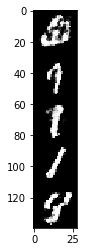

Iter [   29200] Time [264.4514] d_loss [0.6366]


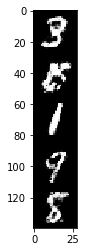

Iter [   29300] Time [264.8110] d_loss [0.5919]


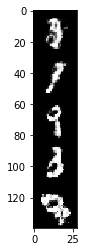

Iter [   29400] Time [265.2186] d_loss [0.6762]


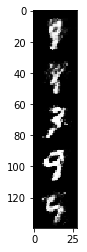

Iter [   29500] Time [265.8538] d_loss [0.6492]


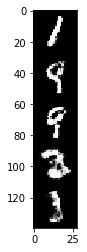

Iter [   29600] Time [266.2664] d_loss [0.6775]


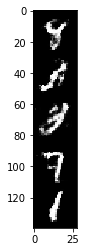

Iter [   29700] Time [266.6999] d_loss [0.6521]


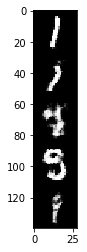

Iter [   29800] Time [267.1265] d_loss [0.5102]


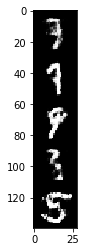

Iter [   29900] Time [267.5296] d_loss [0.4757]


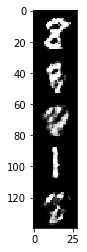

Iter [   30000] Time [267.9475] d_loss [0.6941]


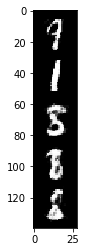

Iter [   30100] Time [268.3773] d_loss [0.5382]


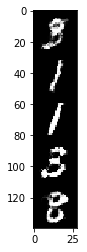

Iter [   30200] Time [268.8098] d_loss [0.6268]


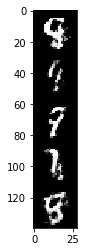

Iter [   30300] Time [269.2249] d_loss [0.8060]


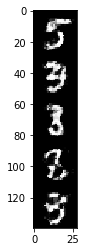

Iter [   30400] Time [269.6274] d_loss [0.5508]


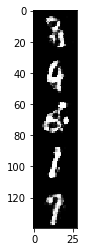

Iter [   30500] Time [270.0561] d_loss [0.6156]


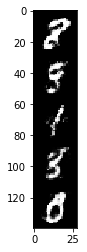

Iter [   30600] Time [270.4804] d_loss [0.7139]


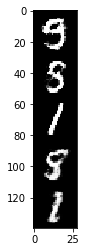

Iter [   30700] Time [270.8928] d_loss [0.6347]


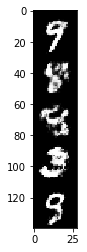

Iter [   30800] Time [271.3351] d_loss [0.7006]


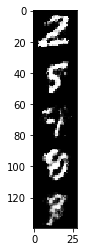

Iter [   30900] Time [271.7697] d_loss [0.7700]


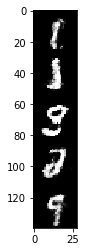

Iter [   31000] Time [272.1497] d_loss [0.5589]


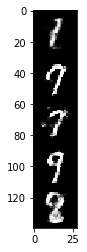

Iter [   31100] Time [272.6838] d_loss [0.6808]


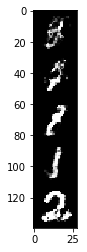

Iter [   31200] Time [273.1064] d_loss [0.7698]


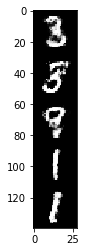

Iter [   31300] Time [273.5016] d_loss [0.6418]


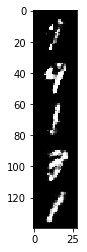

Iter [   31400] Time [273.9211] d_loss [0.6346]


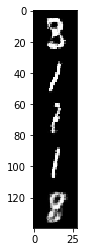

Iter [   31500] Time [274.3675] d_loss [0.6991]


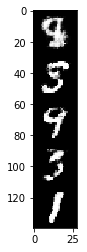

Iter [   31600] Time [274.7500] d_loss [0.6106]


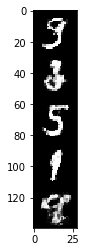

Iter [   31700] Time [275.1761] d_loss [0.5460]


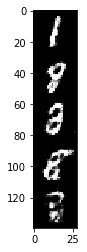

Iter [   31800] Time [275.5895] d_loss [0.6375]


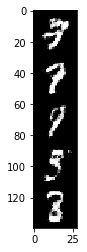

Iter [   31900] Time [275.9832] d_loss [0.5534]


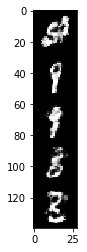

Iter [   32000] Time [276.3847] d_loss [0.4851]


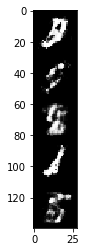

Iter [   32100] Time [276.8188] d_loss [0.6171]


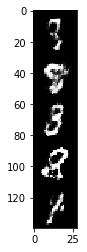

Iter [   32200] Time [277.4331] d_loss [0.5431]


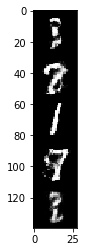

Iter [   32300] Time [278.4248] d_loss [0.3409]


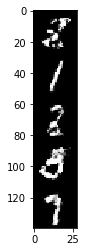

Iter [   32400] Time [279.6304] d_loss [0.7214]


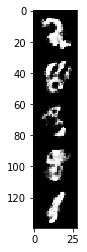

Iter [   32500] Time [280.8932] d_loss [0.5145]


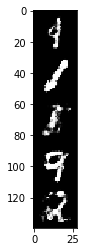

Iter [   32600] Time [282.0510] d_loss [0.5806]


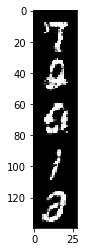

Iter [   32700] Time [283.4229] d_loss [0.7202]


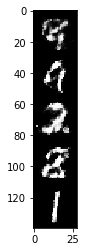

Iter [   32800] Time [284.5582] d_loss [0.5659]


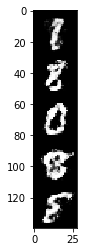

Iter [   32900] Time [285.7686] d_loss [0.6642]


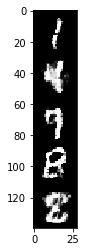

Iter [   33000] Time [287.1051] d_loss [0.6789]


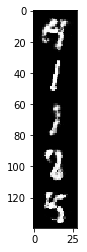

Iter [   33100] Time [288.2310] d_loss [0.7223]


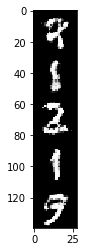

Iter [   33200] Time [289.4885] d_loss [0.7532]


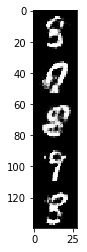

Iter [   33300] Time [290.7289] d_loss [0.6425]


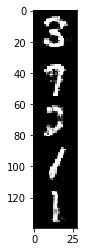

Iter [   33400] Time [291.9906] d_loss [0.5748]


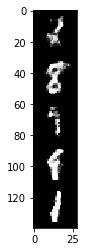

Iter [   33500] Time [293.2496] d_loss [0.8978]


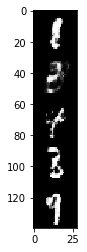

Iter [   33600] Time [294.5501] d_loss [0.6289]


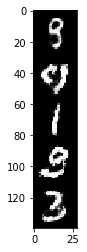

Iter [   33700] Time [295.8824] d_loss [0.6228]


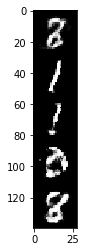

Iter [   33800] Time [297.1499] d_loss [0.8240]


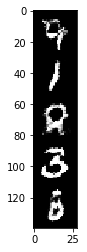

Iter [   33900] Time [298.3414] d_loss [0.5577]


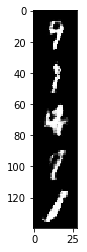

Iter [   34000] Time [299.5718] d_loss [0.7596]


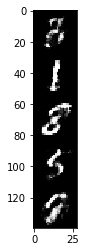

Iter [   34100] Time [300.9486] d_loss [0.6560]


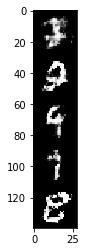

Iter [   34200] Time [302.1600] d_loss [0.5458]


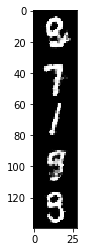

Iter [   34300] Time [303.5094] d_loss [0.7193]


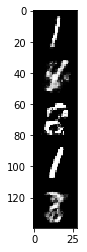

Iter [   34400] Time [304.7995] d_loss [0.6344]


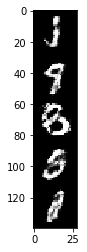

Iter [   34500] Time [306.0506] d_loss [0.6553]


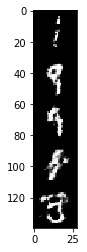

Iter [   34600] Time [307.3990] d_loss [0.5895]


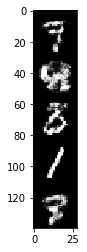

Iter [   34700] Time [308.5523] d_loss [0.6124]


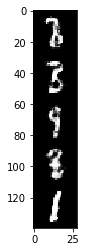

Iter [   34800] Time [309.8607] d_loss [0.8834]


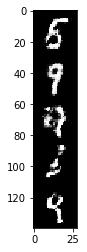

Iter [   34900] Time [311.1409] d_loss [0.7528]


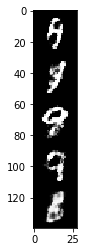

Iter [   35000] Time [312.4217] d_loss [0.5372]


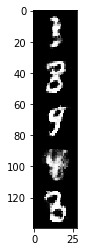

Iter [   35100] Time [313.6345] d_loss [0.7028]


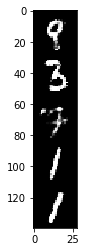

Iter [   35200] Time [314.9941] d_loss [0.6728]


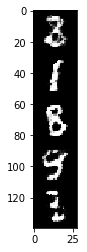

Iter [   35300] Time [316.2891] d_loss [0.6380]


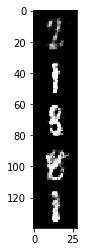

Iter [   35400] Time [317.5811] d_loss [0.4759]


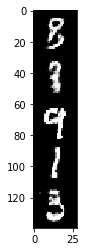

Iter [   35500] Time [318.5841] d_loss [0.8091]


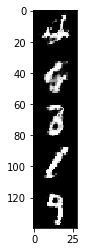

Iter [   35600] Time [319.8282] d_loss [0.6577]


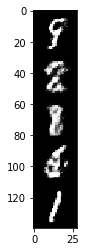

Iter [   35700] Time [321.0692] d_loss [0.5942]


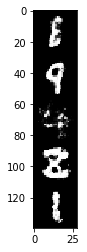

Iter [   35800] Time [322.3586] d_loss [0.5793]


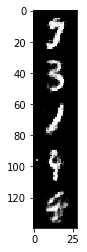

Iter [   35900] Time [323.8545] d_loss [0.5764]


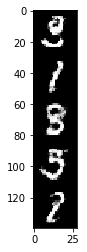

Iter [   36000] Time [325.0483] d_loss [0.5420]


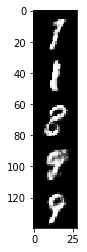

Iter [   36100] Time [326.2068] d_loss [0.8149]


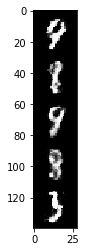

Iter [   36200] Time [327.4230] d_loss [0.6494]


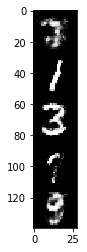

Iter [   36300] Time [328.5913] d_loss [0.6847]


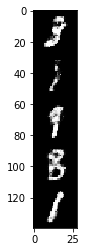

Iter [   36400] Time [329.8442] d_loss [0.5625]


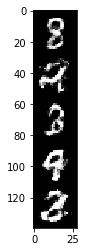

Iter [   36500] Time [330.9478] d_loss [0.4247]


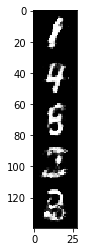

Iter [   36600] Time [332.2138] d_loss [0.5476]


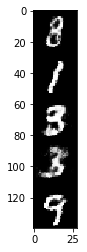

Iter [   36700] Time [333.4589] d_loss [0.4973]


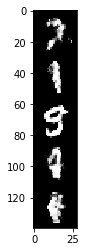

Iter [   36800] Time [334.7362] d_loss [0.5769]


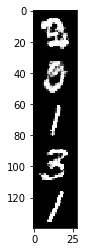

Iter [   36900] Time [336.0657] d_loss [0.6353]


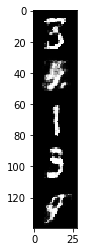

Iter [   37000] Time [337.2443] d_loss [0.5363]


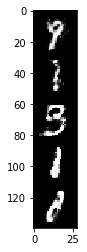

Iter [   37100] Time [338.2361] d_loss [0.6236]


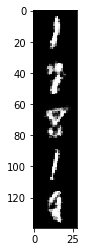

Iter [   37200] Time [339.4577] d_loss [0.6298]


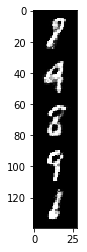

Iter [   37300] Time [340.6663] d_loss [0.6044]


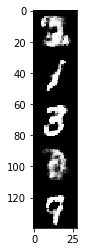

Iter [   37400] Time [341.9358] d_loss [0.7722]


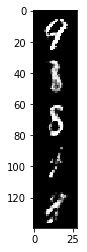

Iter [   37500] Time [343.2839] d_loss [0.6621]


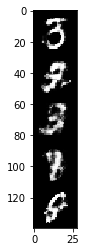

Iter [   37600] Time [344.5702] d_loss [0.5785]


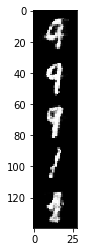

Iter [   37700] Time [345.8514] d_loss [0.6670]


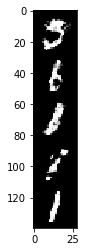

Iter [   37800] Time [347.1631] d_loss [0.6337]


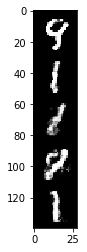

Iter [   37900] Time [348.3734] d_loss [0.7424]


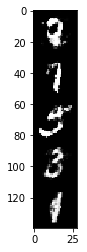

Iter [   38000] Time [349.6774] d_loss [0.4656]


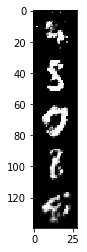

Iter [   38100] Time [350.9235] d_loss [0.7104]


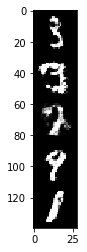

Iter [   38200] Time [352.1110] d_loss [0.4437]


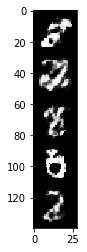

Iter [   38300] Time [353.4465] d_loss [0.6125]


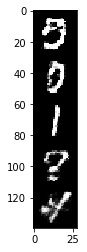

Iter [   38400] Time [354.6510] d_loss [0.6839]


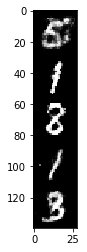

Iter [   38500] Time [356.0146] d_loss [0.5541]


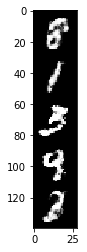

Iter [   38600] Time [357.2652] d_loss [0.5001]


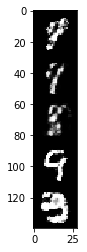

Iter [   38700] Time [358.5626] d_loss [0.5287]


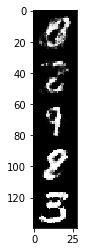

Iter [   38800] Time [359.5881] d_loss [0.6258]


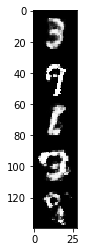

Iter [   38900] Time [360.8047] d_loss [0.5341]


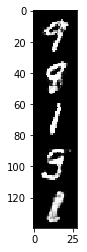

Iter [   39000] Time [362.0110] d_loss [0.6889]


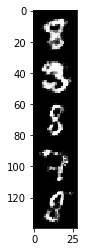

Iter [   39100] Time [363.5005] d_loss [0.5691]


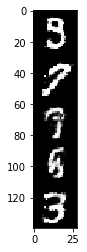

Iter [   39200] Time [364.7980] d_loss [0.5437]


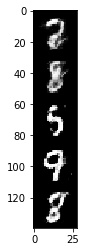

Iter [   39300] Time [366.0462] d_loss [0.5561]


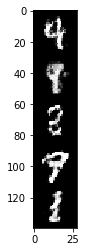

Iter [   39400] Time [367.3300] d_loss [0.7193]


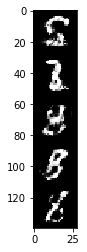

Iter [   39500] Time [368.5722] d_loss [0.6204]


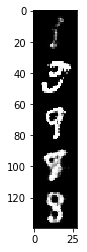

Iter [   39600] Time [369.6194] d_loss [0.7349]


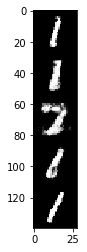

Iter [   39700] Time [370.9864] d_loss [0.6338]


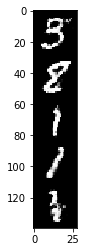

Iter [   39800] Time [372.2326] d_loss [0.5568]


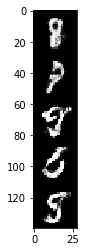

Iter [   39900] Time [373.5640] d_loss [0.6392]


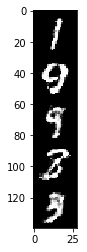

Iter [   40000] Time [374.8014] d_loss [0.5581]


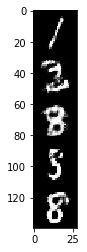

Iter [   40100] Time [376.1305] d_loss [0.6909]


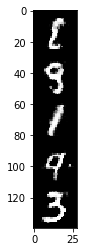

Iter [   40200] Time [377.3716] d_loss [0.8395]


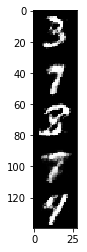

Iter [   40300] Time [378.6127] d_loss [0.6888]


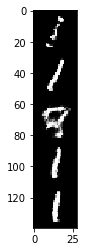

Iter [   40400] Time [379.7278] d_loss [0.5518]


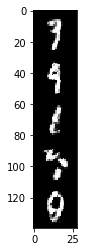

Iter [   40500] Time [380.9084] d_loss [0.6125]


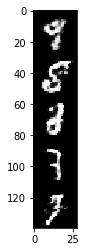

Iter [   40600] Time [382.2468] d_loss [0.5870]


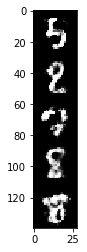

Iter [   40700] Time [383.6217] d_loss [0.6102]


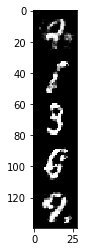

Iter [   40800] Time [384.9421] d_loss [0.4117]


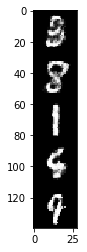

Iter [   40900] Time [386.1434] d_loss [0.7644]


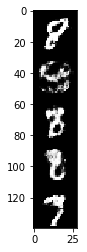

Iter [   41000] Time [387.3738] d_loss [0.6716]


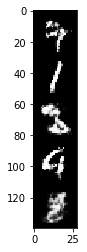

Iter [   41100] Time [388.6084] d_loss [0.7136]


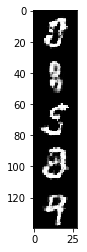

Iter [   41200] Time [389.7454] d_loss [0.6620]


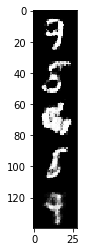

Iter [   41300] Time [391.0977] d_loss [0.9062]


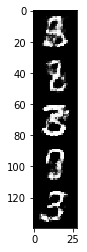

Iter [   41400] Time [392.2873] d_loss [0.5597]


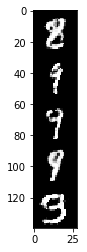

Iter [   41500] Time [393.4856] d_loss [0.6800]


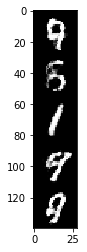

Iter [   41600] Time [394.6731] d_loss [0.8553]


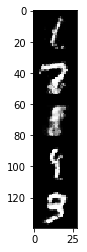

Iter [   41700] Time [395.9135] d_loss [0.5976]


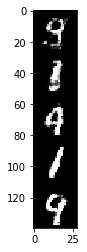

Iter [   41800] Time [397.2675] d_loss [0.5447]


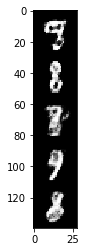

Iter [   41900] Time [398.4701] d_loss [0.7604]


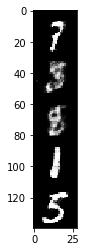

Iter [   42000] Time [399.6006] d_loss [0.8298]


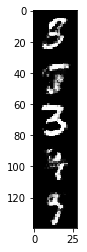

Iter [   42100] Time [400.8208] d_loss [0.6619]


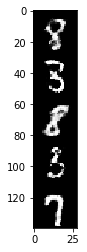

Iter [   42200] Time [402.1062] d_loss [0.7268]


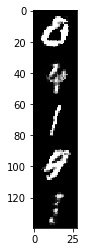

Iter [   42300] Time [403.4859] d_loss [0.5505]


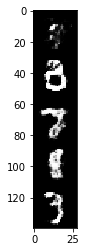

Iter [   42400] Time [404.6888] d_loss [0.6327]


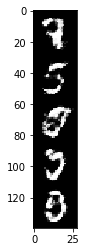

Iter [   42500] Time [405.9990] d_loss [0.5759]


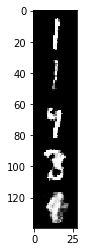

Iter [   42600] Time [407.1909] d_loss [0.6377]


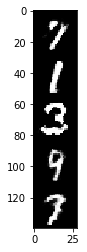

Iter [   42700] Time [408.4455] d_loss [0.4828]


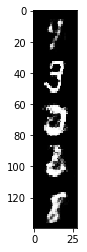

Iter [   42800] Time [409.6432] d_loss [0.6318]


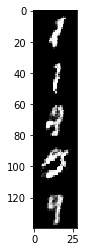

Iter [   42900] Time [410.9290] d_loss [0.6219]


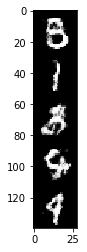

Iter [   43000] Time [412.1795] d_loss [0.5771]


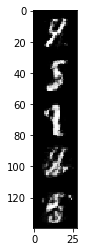

Iter [   43100] Time [413.4362] d_loss [0.5398]


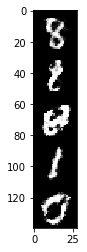

Iter [   43200] Time [414.7685] d_loss [0.6435]


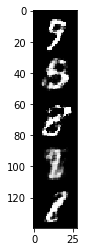

Iter [   43300] Time [415.9821] d_loss [0.5929]


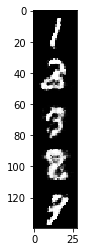

Iter [   43400] Time [417.2650] d_loss [0.5057]


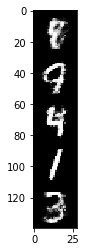

Iter [   43500] Time [418.6353] d_loss [0.4447]


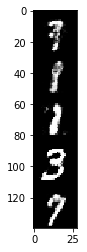

Iter [   43600] Time [419.9353] d_loss [0.5849]


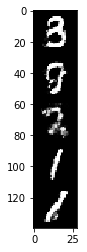

Iter [   43700] Time [420.9931] d_loss [0.6132]


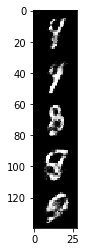

Iter [   43800] Time [422.1874] d_loss [0.6476]


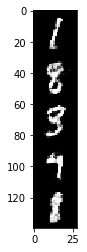

Iter [   43900] Time [423.5020] d_loss [0.5587]


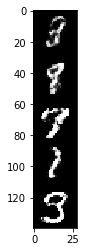

Iter [   44000] Time [424.8629] d_loss [0.5716]


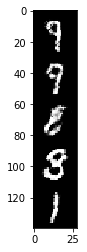

Iter [   44100] Time [426.0910] d_loss [0.5116]


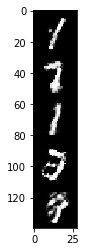

Iter [   44200] Time [427.3419] d_loss [0.4952]


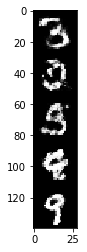

Iter [   44300] Time [428.6393] d_loss [0.5352]


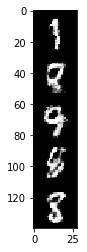

Iter [   44400] Time [429.6863] d_loss [0.6466]


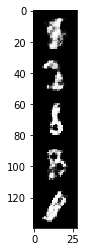

Iter [   44500] Time [430.2022] d_loss [0.6780]


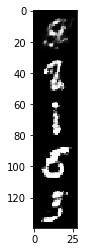

Iter [   44600] Time [430.7146] d_loss [0.5555]


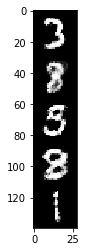

Iter [   44700] Time [431.2081] d_loss [0.7086]


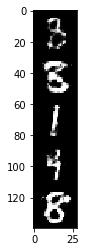

Iter [   44800] Time [431.6193] d_loss [0.8525]


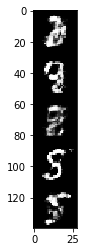

Iter [   44900] Time [432.0504] d_loss [0.4991]


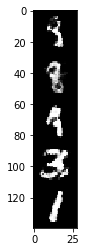

Iter [   45000] Time [432.4508] d_loss [0.6713]


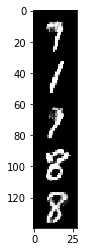

Iter [   45100] Time [432.8958] d_loss [0.6399]


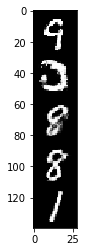

Iter [   45200] Time [433.3248] d_loss [0.5797]


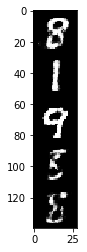

Iter [   45300] Time [433.8023] d_loss [0.8126]


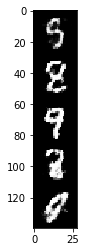

Iter [   45400] Time [434.2265] d_loss [0.5460]


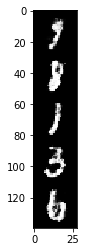

Iter [   45500] Time [434.7915] d_loss [0.4335]


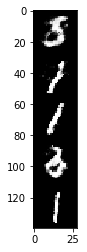

Iter [   45600] Time [435.2467] d_loss [0.4495]


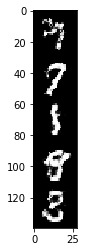

Iter [   45700] Time [435.6660] d_loss [0.5823]


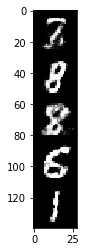

Iter [   45800] Time [436.1015] d_loss [0.5102]


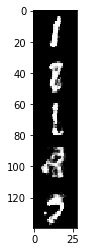

Iter [   45900] Time [436.5512] d_loss [0.6033]


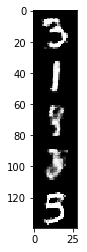

Iter [   46000] Time [436.9445] d_loss [0.9567]


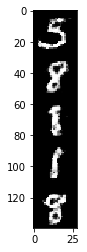

Iter [   46100] Time [437.3079] d_loss [0.6260]


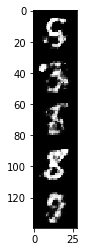

Iter [   46200] Time [437.7415] d_loss [0.5548]


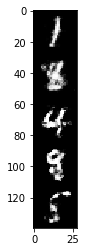

Iter [   46300] Time [438.1284] d_loss [0.6439]


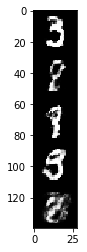

Iter [   46400] Time [438.5354] d_loss [0.6197]


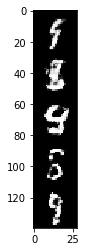

Iter [   46500] Time [438.9659] d_loss [0.6129]


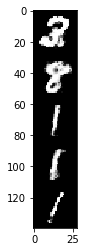

Iter [   46600] Time [439.4134] d_loss [0.6661]


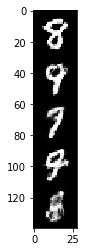

Iter [   46700] Time [439.8630] d_loss [0.5743]


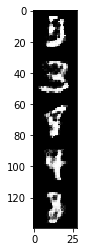

Iter [   46800] Time [440.2948] d_loss [0.5097]


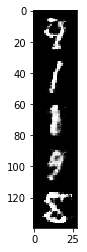

Iter [   46900] Time [440.7406] d_loss [0.8284]


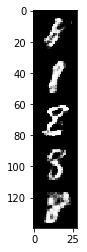

Iter [   47000] Time [441.1314] d_loss [0.6832]


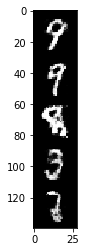

Iter [   47100] Time [441.6826] d_loss [0.5702]


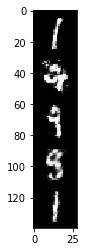

Iter [   47200] Time [442.1202] d_loss [0.5944]


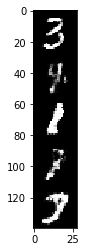

Iter [   47300] Time [442.5687] d_loss [0.5700]


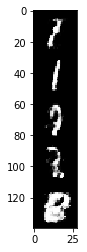

Iter [   47400] Time [442.9529] d_loss [0.4696]


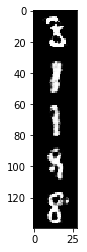

Iter [   47500] Time [443.3612] d_loss [0.6309]


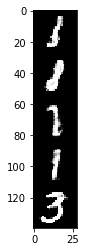

Iter [   47600] Time [443.7315] d_loss [0.4055]


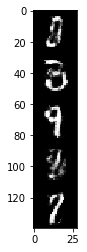

Iter [   47700] Time [444.1275] d_loss [0.6032]


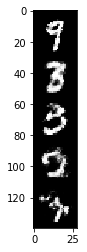

Iter [   47800] Time [444.5399] d_loss [0.6080]


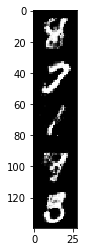

Iter [   47900] Time [445.0588] d_loss [0.7961]


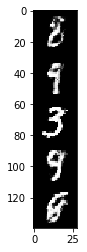

Iter [   48000] Time [445.4930] d_loss [0.7315]


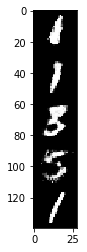

Iter [   48100] Time [445.9503] d_loss [0.5630]


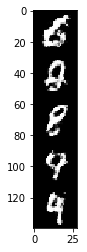

Iter [   48200] Time [446.3599] d_loss [0.6194]


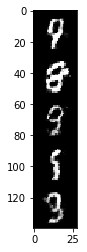

Iter [   48300] Time [446.8429] d_loss [0.6037]


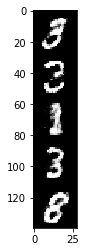

Iter [   48400] Time [447.2650] d_loss [0.6514]


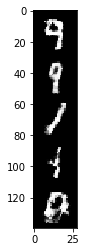

Iter [   48500] Time [447.7139] d_loss [0.6963]


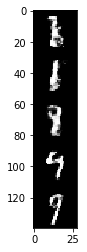

Iter [   48600] Time [448.1379] d_loss [0.7621]


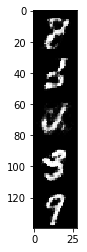

Iter [   48700] Time [448.7086] d_loss [0.5550]


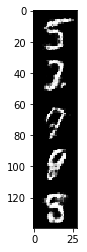

Iter [   48800] Time [449.1146] d_loss [0.8413]


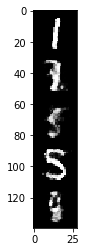

Iter [   48900] Time [449.5155] d_loss [0.5326]


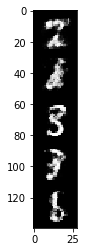

Iter [   49000] Time [449.9389] d_loss [0.7872]


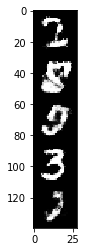

Iter [   49100] Time [450.3727] d_loss [0.5857]


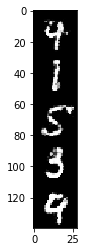

Iter [   49200] Time [450.7378] d_loss [0.5949]


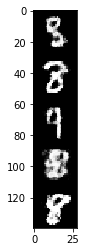

Iter [   49300] Time [451.1411] d_loss [0.7675]


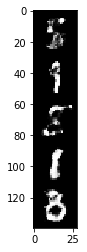

Iter [   49400] Time [451.5744] d_loss [0.7473]


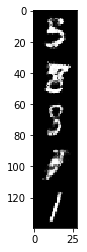

Iter [   49500] Time [452.0186] d_loss [0.5892]


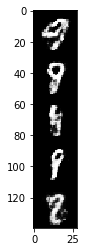

Iter [   49600] Time [452.4336] d_loss [0.5741]


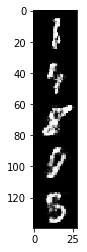

Iter [   49700] Time [452.8730] d_loss [0.4772]


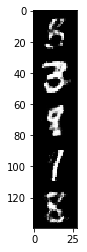

Iter [   49800] Time [453.3254] d_loss [0.5909]


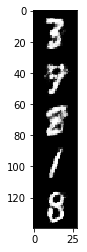

Iter [   49900] Time [453.7619] d_loss [0.7194]


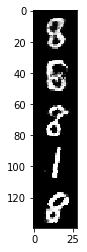

Iter [   49999] Time [454.1611] d_loss [0.5223]


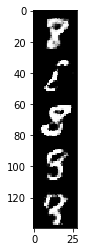

In [59]:
tf.reset_default_graph()
train_gan(50000)